# Waveform Tutorial

## Notes

Example to generate waveforms with `TEOBResumS`. The script is meant to display the basic functionalities of `EOBRun_module`. 

More features are illustrated in the other `Example*` scripts present in the TEOBResumS folder.

If you use `TEOBResumS` for your research, please cite the relevant papers listed in https://bitbucket.org/eob_ihes/teobresums/wiki/References

## Generate a Waveform

### Step 0: install and import the module
In general, to install `TEOBResumS-GIOTTO` you can either:
* Install from source: clone this repository and do
```
cd teobresums/Python
python setup.py install
```
* Install from PyPI
```
pip install teobresums
```

Then, import the module as below.

**However**, since we want to work with eccentric waveforms, pip installation is not available. We need to clone the repository and checkout the `eccentric` branch. Then, proceed with the installation from source as described above.

In [2]:
import EOBRun_module
import matplotlib.pyplot as plt; import numpy as np;

### Step 1: define the initial frequency and the intrinsic parameters of the system 

In this example we will generate the waveform from a nonspinning, quasi-circular black hole binary.

In [3]:
# Input parameters
M                  = 60.           # Total mass of the desired system
q, s1, s2          = 1.2, 0., 0.  # q (>1), s1z, s2z
initial_frequency  = 5

In [4]:
# Select the modes to use in the hp, hc computation

def modes_to_k(modes):
    """
    Convert a list of modes to EOB conventions
    """
    return [int(x[0]*(x[0]-1)/2 + x[1]-2) for x in modes]

modes = [(2,1),(2,2),(3,3)]
modes_k = modes_to_k(modes)

### Step 2: create the parameters dictionary

The waveform generator requires as input a dictionary of parameters, see https://bitbucket.org/eob_ihes/teobresums/wiki/Conventions,%20parameters%20and%20output for a complete list.

In [5]:
pars = {
    # System parametes, assuming aligned spins        
    'M'                  : M,      # Total mass
    'q'                  : q,      # Mass ratio m1/m2 > 1
    'chi1'               : s1,     # Z component of chi_1
    'chi2'               : s2,     # Z component of chi_2
    'LambdaAl2'          : 0.,     # Quadrupolar tidal parameter of body 1 (A)
    'LambdaBl2'          : 0.,     # Quadrupolar tidal parameter of body 2 (B)
    'ecc'                : 0.5,    # eccentricity of the orbit
    'ecc_freq'           : 2,      # Use periastron (0), average (1) or apastron (2) frequency for initial condition computation. Default = 1

    
    # Initial conditions and output time grid
    'domain'             : 0,      # Time domain. EOBSPA is not available for eccentric waveforms!
    'srate_interp'       : 4096.,  # srate at which to interpolate. Default = 4096 for physical units.
    'use_geometric_units': 0,   # output quantities in geometric units. Default = 1 /yes)
    'initial_frequency'  : initial_frequency,     # in Hz if use_geometric_units = 0, else in geometric units
    'interp_uniform_grid': 1,  # interpolate mode by mode on a uniform grid. Default = 0 (no interpolation)
    
    # Modes
    'use_mode_lm'        : modes_k,    # List of modes to use/output through EOBRunPy.

    # Output parameters (Python)
    'arg_out'            : 1,  # Output hlm/hflm. Default = 0 (no)
    'output_hpc'         : 0,  # Create an output folder with the waveform
    }

### Step 3: generate the waveform and plot

Depending on the value of the `arg_out` flag, the (time domain) waveform generator returns
* `t, hp, hc` (if `arg_out = 0`) 
* `t, hp, hc, hlm, dyn` (if `arg_out = 1`)

where:
* `t`  = array of times at which the waveform is evaluated
* `hp` = plus polarization
* `hc` = cross polarization
* `hlm` = dictionary of modes $h_{\ell, m}$, separated in amplitude and phase
* `dyn` = dictionary containing the EOB dynamics evolution

In [6]:
# run the wf generator
t, hp, hc, hlm, dyn = EOBRun_module.EOBRunPy(pars)

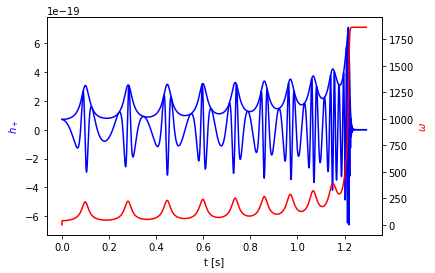

In [7]:
# compute amplitude, phase, omega
A       = np.abs(hp -1j*hc)
p       = -np.unwrap(np.angle(hp -1j*hc))
omg     = np.zeros_like(p)
omg[1:] = np.diff(p)/np.diff(t)

_, ax1  = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(t, hp, color='b', linestyle='-')
ax1.plot(t, A, color='b')
ax2.plot(t, omg, color='r')
ax1.set_xlabel("t [s]")
ax1.set_ylabel(r'$h_+$', color='b')
ax2.set_ylabel('$\omega$', color='r')
plt.show()

### Optional: extract modes $h_{\ell,m}$ and dynamics


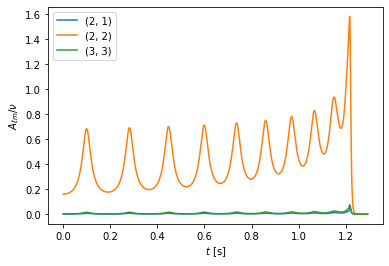

In [8]:
# Plot the modes amplitudes

for mode in range(len(modes_k)):
    klm = modes_k[mode]
    Alm = hlm[str(klm)][0] # the first entry is an array containing A_lm(t)
    plm = hlm[str(klm)][1] # the second entry is an array containing p_lm(t)
    plt.plot(t, Alm, label=str(modes[mode]))

plt.xlabel("$t$ [s]")
plt.ylabel(r"$A_{\ell m}/\nu$")
plt.legend()
plt.show()

In [9]:
# Extract the dynamics

print("EOB Dynamics variables: ", list(dyn.keys()))

EOB Dynamics variables:  ['t', 'r', 'phi', 'Pphi', 'MOmega', 'ddor', 'Prstar', 'MOmega_orb', 'E']


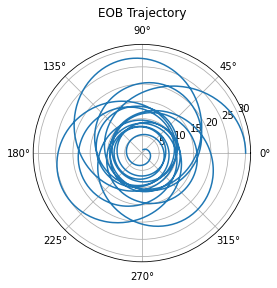

In [10]:
# Plot the EOB trajectory

r     = dyn['r']
phi   = dyn['phi']

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(phi, r)
ax.grid(True)
ax.set_title("EOB Trajectory", va='bottom')
plt.show()

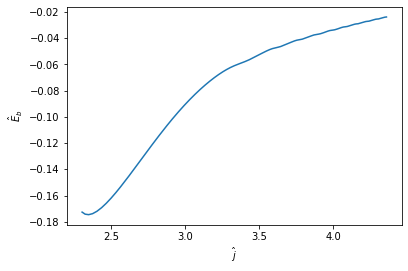

In [11]:
# Plot the binding energy vs angular momentum

nu = q/(1.+q)**2

j = dyn['Pphi']
E = dyn['E']
Eb = (E-1)/nu

plt.plot(j, Eb)
plt.xlabel('$\hat{j}$')
plt.ylabel('$\hat{E}_b$')
plt.show()

## Generate a Dyn capture waveform

To generate a dynamical capture waveform we can proceed exactly as done above. However, this time we will not be
giving eccentricity and initial frequency as input parameters. Rather, we will use:
* $H_{\rm hyp}$, initial EOB energy
* $j_{\rm hyp}$, initial EOB angular momentum
* $r_{\rm hyp}$, initial EOB radial separation

In [12]:
pars_hyp = {
     # System parametes, assuming aligned spins        
    'M'                  : 50.,      # Total mass
    'q'                  : 1.1,      # Mass ratio m1/m2 > 1
    'chi1'               : 0,     # Z component of chi_1
    'chi2'               : 0,     # Z component of chi_2
    'LambdaAl2'          : 0.,     # Quadrupolar tidal parameter of body 1 (A)
    'LambdaBl2'          : 0.,     # Quadrupolar tidal parameter of body 2 (B)
    'H_hyp'              : 1.0027,  # Initial E_eob
    'j_hyp'              : 4.0,    # initial pphi_eob
    'r_hyp'              : 100,   # initial ratial separation
    
    # Initial conditions and output time grid
    'domain'             : 0,      # Time domain. EOBSPA is not available for eccentric waveforms!
    'srate_interp'       : 300000, # Srate at which to interpolate. Default = 4096.
    'use_geometric_units': 0,   # output quantities in geometric units. Default = 1
    'interp_uniform_grid': 1,  # interpolate mode by mode on a uniform grid. Default = "no" (no interpolation)

    # Modes
    'use_mode_lm'        : [1],    # List of modes to use/output through EOBRunPy.

    # ode
    'ode_tmax'           : 20e4,

    # Output parameters (Python)
    'arg_out'            : 1,  # Output hlm/hflm. Default = "no"
    'output_hpc'         : 0,              # Output waveform. Default = 1.
    }

In [13]:
# run the wf generator
t, hp, hc, hlm, dyn = EOBRun_module.EOBRunPy(pars_hyp)

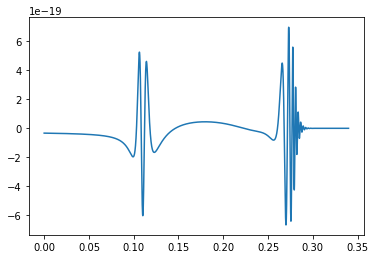

In [14]:
plt.plot(t, hp)
plt.show()

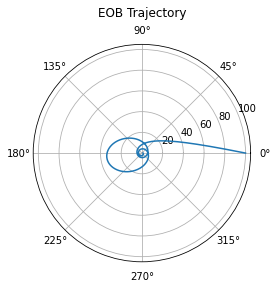

In [15]:
# Plot the EOB trajectory

r     = dyn['r']
phi   = dyn['phi']

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(phi, r)
ax.grid(True)
ax.set_title("EOB Trajectory", va='bottom')
plt.show()